In [1]:
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A

In [2]:
def show(image):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)

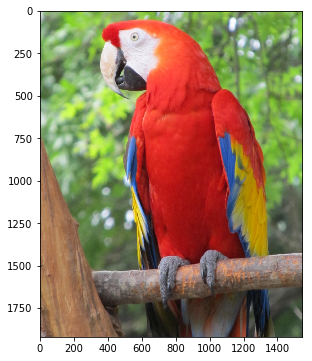

In [3]:
# Let's load an image
image = cv2.imread('./images/parrot.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
show(image)

## Using A.save() and A.load() to serialize a transform pipeline to a JSON or YAML file

### We define a transform pipeline

In [4]:
transform = A.Compose([
    A.RandomCrop(768, 768),
    A.OneOf([
        A.RGBShift(), 
        A.HueSaturationValue()
    ]),
])
print(transform)

Compose([
  RandomCrop(always_apply=False, p=1.0, height=768, width=768),
  OneOf([
    RGBShift(always_apply=False, p=0.5, r_shift_limit=(-20, 20), g_shift_limit=(-20, 20), b_shift_limit=(-20, 20)),
    HueSaturationValue(always_apply=False, p=0.5, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-20, 20)),
  ], p=0.5),
], p=1.0, bbox_params={}, keypoint_params={}, additional_targets={})


### Next, we fix the random seed so we can reproduce the result later, then we pass the image through the pipeline and show an augmented version.

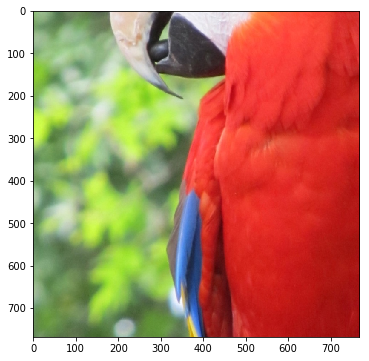

In [5]:
random.seed(42)
augmented_image_1 = transform(image=image)['image']
show(augmented_image_1)

### To serialize an augmentation pipeline to a JSON file, you need to call `A.save` and pass the pipeline and a path to a file.

In [6]:
A.save(transform, '/tmp/transform.json')

### To load a serialized pipeline, you need to call `A.load` and pass a path to a file with a serialized version of the pipeline

In [7]:
loaded_transform = A.load('/tmp/transform.json')
print(loaded_transform)

Compose([
  RandomCrop(always_apply=False, p=1.0, height=768, width=768),
  OneOf([
    RGBShift(always_apply=False, p=0.5, r_shift_limit=(-20, 20), g_shift_limit=(-20, 20), b_shift_limit=(-20, 20)),
    HueSaturationValue(always_apply=False, p=0.5, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-20, 20)),
  ], p=0.5),
], p=1.0, bbox_params={}, keypoint_params={}, additional_targets={})


### Next, we use the same seed as before, pass the image through the deserialized pipeline and make sure that the original and the deserialized pipelines produce the same result.

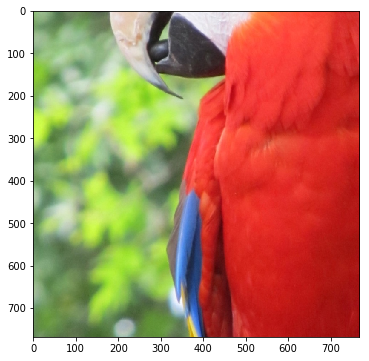

In [8]:
random.seed(42)
augmented_image_2 = loaded_transform(image=image)['image']
show(augmented_image_2)

In [9]:
assert np.array_equal(augmented_image_1, augmented_image_2)

### You can also serialize pipeline to a YAML file by providing `data_format = 'yaml'`.

In [10]:
A.save(transform, '/tmp/transform.yml', data_format='yaml')
loaded_transform = A.load('/tmp/transform.yml', data_format='yaml')

## Using `A.to_dict()` and `A.from_dict()` to serialize a transform pipeline to a Python dictionary.

### If you need more control over a serialized pipeline, e.g., you want to save a serialized version to a database or send it to a server you can use the `A.to_dict` and `A.from_dict` functions. `A.to_dict` returns a Python dictionary that describes a pipeline. The dictionary will contain only primitive data types such as dictionaries, lists, strings, integers, and floats. To construct a pipeline from a dictionary, you need to call `A.from_dict`.

In [11]:
transform_dict = A.to_dict(transform)
loaded_transform = A.from_dict(transform_dict)
print(loaded_transform)

Compose([
  RandomCrop(always_apply=False, p=1.0, height=768, width=768),
  OneOf([
    RGBShift(always_apply=False, p=0.5, r_shift_limit=(-20, 20), g_shift_limit=(-20, 20), b_shift_limit=(-20, 20)),
    HueSaturationValue(always_apply=False, p=0.5, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-20, 20)),
  ], p=0.5),
], p=1.0, bbox_params={}, keypoint_params={}, additional_targets={})


## Serializing and deserializing Lambda transforms

### Lambda transforms use custom transformation functions provided by a user. For Lambda transforms only name and position in a transform pipeline are saved. When deserialing a pipeline, you need to manually provide all instances of Lambda transform using the `lambda_transforms` argument.

In [12]:
# Define a function that will be used to transform an image
def hflip_image(image, **kwargs):
    return cv2.flip(image, 1)

In [13]:
# Make a Lambda transform. Note that to make the transform serializable, you need to pass the `name` argument.
hflip_transform = A.Lambda(name='hflip_image', image=hflip_image, p=0.5)
print(hflip_transform)

Lambda(name='hflip_image', image=<function hflip_image at 0x1343c1598>, mask=<function noop at 0x13470eea0>, keypoint=<function noop at 0x13470eea0>, bbox=<function noop at 0x13470eea0>, always_apply=False, p=0.5)


/Users/alexparinov/projects/albumentations/albumentations/augmentations/transforms.py:1907: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn('Using lambda is incompatible with multiprocessing. '


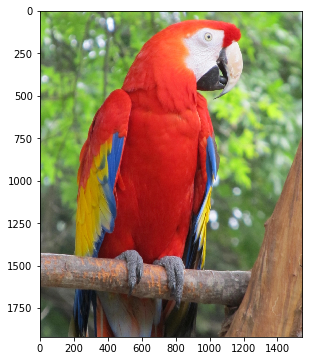

In [14]:
# Apply the transform to an image
random.seed(1)
flipped_image_1 = hflip_transform(image=image)['image']
show(flipped_image_1)

### To serialize a Lambda transform you use the same functions `A.to_dict` and `A.save`

In [15]:
transform_dict = A.to_dict(hflip_transform)
print(transform_dict)

{'__version__': '0.3.0', 'transform': {'__type__': 'Lambda', '__name__': 'hflip_image'}}


### To deserialize a Lambda transform, you need to pass all instances of used Lambda transforms in the `lambda_transforms` argument.

In [16]:
loaded_transform = A.from_dict(transform_dict, lambda_transforms={'hflip_image': hflip_transform})
print(loaded_transform)

Lambda(name='hflip_image', image=<function hflip_image at 0x1343c1598>, mask=<function noop at 0x13470eea0>, keypoint=<function noop at 0x13470eea0>, bbox=<function noop at 0x13470eea0>, always_apply=False, p=0.5)


### Next, we test that deserialized transform produces the same output

In [17]:
random.seed(1)
flipped_image_2 = loaded_transform(image=image)['image']
assert np.array_equal(flipped_image_1, flipped_image_2)

### For `A.load` you also need to provide the `lambda_transforms` argument

In [18]:
A.save(hflip_transform, '/tmp/hflip_transform.json')
loaded_transform = A.load('/tmp/hflip_transform.json', lambda_transforms={'hflip_image': hflip_transform})
print(loaded_transform)

Lambda(name='hflip_image', image=<function hflip_image at 0x1343c1598>, mask=<function noop at 0x13470eea0>, keypoint=<function noop at 0x13470eea0>, bbox=<function noop at 0x13470eea0>, always_apply=False, p=0.5)
